# HSCT survival: gradient boosting decision tree model

## Notebook set-up

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error
from lifelines.utils import concordance_index

import configuration as config
import functions.helper as helper_funcs

# Data files
training_features_df_file=f'{config.DATA_PATH}/processed/02.1-scaled_encoded_training_features_df.parquet'
training_labels_df_file=f'{config.DATA_PATH}/processed/02.1-scaled_encoded_training_labels_df.parquet'
raw_training_features_file=f'{config.DATA_PATH}/raw/train.csv'
testing_features_df_file=f'{config.DATA_PATH}/processed/02.1-scaled_encoded_testing_features_df.parquet'

# Model files
naive_model_file=f'{config.MODELS_PATH}/05.1-gradient_boosting_naive.pkl'
tuned_model_file=f'{config.MODELS_PATH}/05.2-gradient_boosting_tuned.pkl'

retune_model=False

## 1. Load data

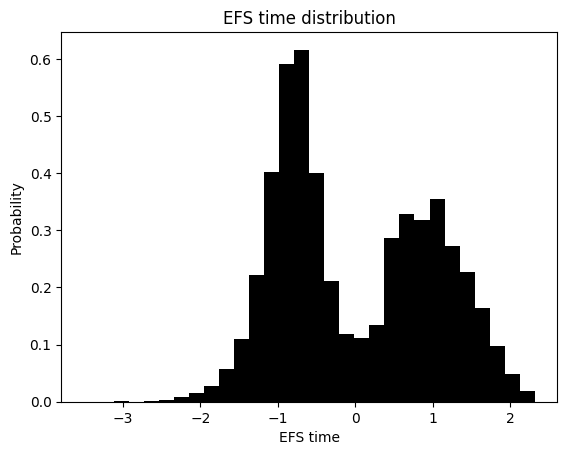

Training features: (28800, 182)


In [2]:
features_df=pd.read_parquet(training_features_df_file)
labels_df=pd.read_parquet(training_labels_df_file)

df=pd.concat([features_df.reset_index(drop=True),labels_df.reset_index(drop=True)],axis=1)

raw_training_df=pd.read_csv(raw_training_features_file)
df['race_group']=raw_training_df['race_group']

plt.title('EFS time distribution')
plt.hist(df['efs_time'], density=True, bins=30, color='black')
plt.xlabel('EFS time')
plt.ylabel('Probability')
plt.show()

print(f'Training features: {df.shape}')

## 2. Train-test split

In [3]:
training, testing=train_test_split(df, test_size=0.33, random_state=315)

training_df=pd.DataFrame(training, columns=df.columns)
testing_df=pd.DataFrame(testing, columns=df.columns)

training_labels_df=training_df[['efs', 'efs_time']]
training_features_df=training_df.drop(['efs', 'efs_time'], axis=1)

testing_labels_df=testing_df[['efs', 'efs_time']]
testing_features_df=testing_df.drop(['efs', 'efs_time'], axis=1)

## 3. Naive model

In [4]:
naive_model=GradientBoostingRegressor(random_state=315)

## 4. Cross-validate naive model

In [5]:
# Run cross-validation to estimate out-of-sample performance
scores=helper_funcs.cross_val(
    naive_model,
    training_features_df.drop(['ID','race_group'], axis=1),
    training_labels_df['efs_time'],
    folds=30
)

cross_val_scores={'Naive model': scores}

Cross validation RMSE 0.91 +/- 0.02


## 5. Fit and evaluate naive model on test set

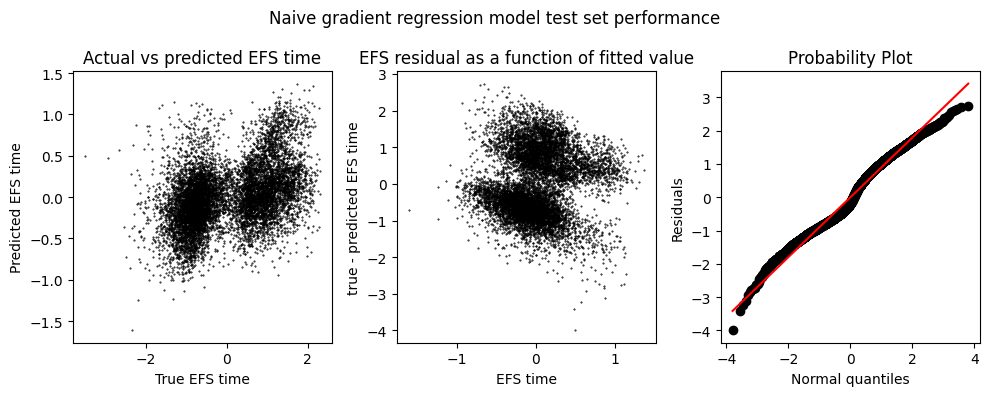

In [6]:
# Fit the model
naive_model.fit(
    training_features_df.drop(['ID','race_group'], axis=1),
    training_labels_df['efs_time']
)

# Make predictions for the whole test set
predicted_efs_time=naive_model.predict(testing_features_df.drop(['ID','race_group'], axis=1))

# Get and save the RMSE for later
rmse=root_mean_squared_error(testing_labels_df['efs_time'], predicted_efs_time)
rmse_results={'Naive model': rmse}

# Get and save the concordance index for later
cindex=concordance_index(
    testing_labels_df['efs_time'],
    predicted_efs_time,
    testing_labels_df['efs']
)

cindex_results={'Naive model': cindex}

# Get and save stratified concordance index for later
submission=pd.DataFrame({'ID': testing_df['ID'], 'prediction': predicted_efs_time})
score=helper_funcs.competition_score(testing_df, submission)
stratified_cindex_results={'Naive model': score}

# Plot the results
fig, axs=plt.subplots(1,3, figsize=(10,4))
axs=axs.flatten()

fig.suptitle('Naive gradient regression model test set performance')

axs[0].set_title('Actual vs predicted EFS time')
axs[0].scatter(testing_labels_df['efs_time'], predicted_efs_time, color='black', s=0.2)
axs[0].set_xlabel('True EFS time')
axs[0].set_ylabel('Predicted EFS time')

axs[1].set_title('EFS residual as a function of fitted value')
axs[1].scatter(predicted_efs_time, testing_labels_df['efs_time'] - predicted_efs_time, color='black', s=0.2)
axs[1].set_xlabel('EFS time')
axs[1].set_ylabel('true - predicted EFS time')

axs[2].set_title('Normal quantile plot')
stats.probplot(testing_labels_df['efs_time'] - predicted_efs_time, plot=axs[2])
axs[2].get_lines()[0].set_markeredgecolor('black')
axs[2].get_lines()[0].set_markerfacecolor('black')
axs[2].set_xlabel('Normal quantiles')
axs[2].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

In [7]:
# Save the model
with open(naive_model_file, 'wb') as output_file:
    pickle.dump(naive_model, output_file)

## 6. Hyperparameter tuning

In [8]:
# Train or load model as desired
if retune_model == True:
    
    # Instantiate the model
    model=GradientBoostingRegressor(random_state=315)

    # Define the cross-validation strategy
    cross_validation=KFold(n_splits=7, shuffle=True, random_state=315)

    # Define the hyperparameter search space
    distributions={
        'learning_rate': stats.uniform(loc=0.0001, scale=0.0999),
        'n_estimators': list(range(5, 100)),
        'max_depth': list(range(5, 50)),
        'min_samples_split': list(range(2, 50)),
        'min_samples_leaf': list(range(1, 50)),
        'subsample': stats.uniform(loc=0.5, scale=0.4)
    }

    # Set-up the search
    search=RandomizedSearchCV(
        model,
        distributions,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        cv=cross_validation,
        n_iter=200,
        random_state=315,
        return_train_score=True
    )

    results=search.fit(
        training_features_df.drop(['ID','race_group'], axis=1),
        training_labels_df['efs_time']
    )
    
    print(f'Best hyperparameters: {results.best_params_}')

    # Instantiate the model with the tuned hyperparameters
    tuned_model=GradientBoostingRegressor(**results.best_params_, random_state=315)

    tuned_model.fit(
        training_features_df.drop(['ID','race_group'], axis=1),
        training_labels_df['efs_time']
    )

    with open(tuned_model_file, 'wb') as output_file:
        pickle.dump(tuned_model, output_file)
    
elif retune_model == False:
    with open(tuned_model_file, 'rb') as input_file:
        tuned_model=pickle.load(input_file)

## 7. Cross-validate tuned model

In [9]:
# Run cross-validation to estimate out-of-sample performance
scores=helper_funcs.cross_val(
    tuned_model,
    training_features_df.drop(['ID','race_group'], axis=1),
    training_labels_df['efs_time'],
    folds=30
)

cross_val_scores['Tuned model']=scores

Cross validation RMSE 0.91 +/- 0.02


## 8. Fit and evaluate tuned model on test set

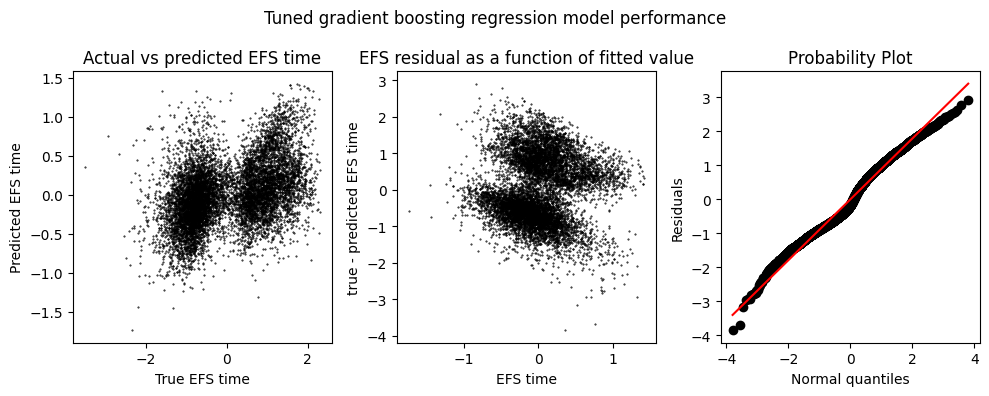

In [10]:
# Make predictions on the training set
predicted_efs_time=tuned_model.predict(testing_features_df.drop(['ID','race_group'], axis=1))

# Save the RMSE for later
rmse_results['Tuned model']=root_mean_squared_error(testing_labels_df['efs_time'], predicted_efs_time)

# Save the concordance index for later
cindex_results['Tuned model']=concordance_index(
    testing_labels_df['efs_time'],
    predicted_efs_time,
    testing_labels_df['efs']
)

# Get and save stratified concordance index for later
submission=pd.DataFrame({'ID': testing_df['ID'], 'prediction': predicted_efs_time})
stratified_cindex_results['Tuned model']=helper_funcs.competition_score(testing_df, submission)

# Plot the results
fig, axs=plt.subplots(1,3, figsize=(10,4))
axs=axs.flatten()

fig.suptitle('Tuned gradient boosting regression model performance')

axs[0].set_title('Actual vs predicted EFS time')
axs[0].scatter(testing_labels_df['efs_time'], predicted_efs_time, color='black', s=0.2)
axs[0].set_xlabel('True EFS time')
axs[0].set_ylabel('Predicted EFS time')

axs[1].set_title('EFS residual as a function of fitted value')
axs[1].scatter(predicted_efs_time, testing_labels_df['efs_time'] - predicted_efs_time, color='black', s=0.2)
axs[1].set_xlabel('EFS time')
axs[1].set_ylabel('true - predicted EFS time')

axs[2].set_title('Normal quantile plot')
stats.probplot(testing_labels_df['efs_time'] - predicted_efs_time, plot=axs[2])
axs[2].get_lines()[0].set_markeredgecolor('black')
axs[2].get_lines()[0].set_markerfacecolor('black')
axs[2].set_xlabel('Normal quantiles')
axs[2].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

## 9. Model comparison

### 9.1. Cross-validation performance

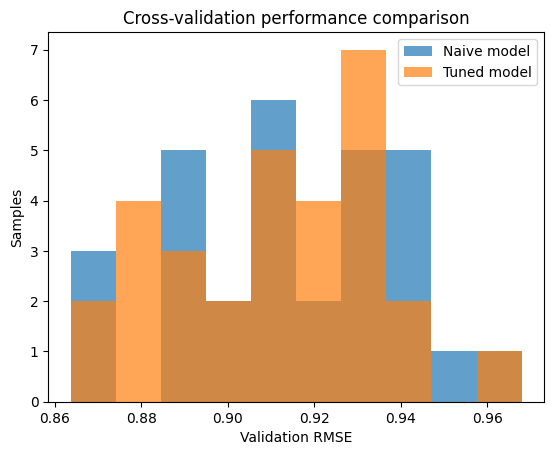

In [11]:
import numpy as np

# Collect scores
joined_scores=[]

for scores in cross_val_scores.values():
    joined_scores.extend(scores)

_, bins=np.histogram(joined_scores)

plt.title('Cross-validation performance comparison')

for model, scores in cross_val_scores.items():
    plt.hist(scores, bins=bins, alpha=0.7, label=model)
    
plt.xlabel('Validation RMSE')
plt.ylabel('Samples')
plt.legend(loc='best')
plt.show()

### 9.2. Test set performance

#### 9.2.1 RMSE

In [12]:
for model, score in rmse_results.items():
    print(f'{model} RMSE: {score}')

Naive model RMSE: 0.9089062359952856
Tuned model RMSE: 0.9044046673721885


#### 9.2.2. Concordance index

In [13]:
for model, score in cindex_results.items():
    print(f'{model} concordance index: {score}')

Naive model concordance index: 0.6537202586876403
Tuned model concordance index: 0.6578825456445304


#### 9.2.3. Stratified concordance index

In [14]:
for model, score in stratified_cindex_results.items():
    print(f'{model} stratified concordance index: {score}')

Naive model stratified concordance index: 0.33629497155218757
Tuned model stratified concordance index: 0.33300374737369953


## 10. Make test set predictions

In [15]:
testing_features_df=pd.read_parquet(testing_features_df_file)
ids=testing_features_df['ID']
testing_features_df.drop('ID', axis=1, inplace=True)
predicted_efs_time=tuned_model.predict(testing_features_df)
scaler=MinMaxScaler()
scaler.fit(predicted_efs_time.reshape(-1, 1))
predicted_efs_time=scaler.transform(predicted_efs_time.reshape(-1, 1))

predictions_df=pd.DataFrame.from_dict({'ID': ids, 'prediction': predicted_efs_time.flatten()})
predictions_df.describe()

,ID,prediction
count,3.0,3.000000
mean,28801.0,0.481748
std,1.0,0.500998
min,28800.0,0.000000
25%,28800.5,0.222623
50%,28801.0,0.445245
75%,28801.5,0.722623
max,28802.0,1.000000
